In [1]:
%matplotlib inline
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform
from pymc3 import forestplot, traceplot, plot_posterior, summary
import seaborn as sns

In [2]:
trend2=pd.read_csv('/home/ayca/Documents/trend2.csv')
trend2.columns = trend2.columns.map(str.strip)
trend2 = trend2.dropna(axis = 0, how = 'any')
trend2 = trend2.reset_index()
trend2 = trend2.drop('index', 1)

trend2.head(600)

,country,year,church2,cc,gini_net,rgdpl
0,Australia,1965,26.182790,Australia,29.16514,15.23929
1,Australia,1967,24.744380,Australia,29.50664,16.25018
2,Australia,1979,4.442971,Australia,25.75894,21.58357
3,Australia,1981,27.626460,Australia,28.10000,22.46979
4,Australia,1984,18.099700,Australia,28.80875,23.45019
...,...,...,...,...,...,...
583,United States,2003,31.000000,United States,37.16354,39.79302
584,United States,2004,25.051880,United States,37.20000,40.91001
585,United States,2005,31.425200,United States,37.08701,42.53482
586,United States,2006,29.700130,United States,36.87890,43.25840


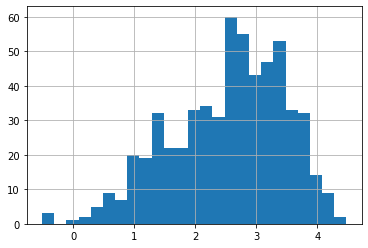

In [3]:
trend2.church2.apply(lambda x: np.log(x+1e-1)).hist(bins = 25);

In [4]:
trend2.country = trend2.country.map(str.strip)
countries = trend2.country.unique()
numberOfCountries = len(countries)
countryLookup = dict(zip(countries, range(numberOfCountries)))

In [5]:
country = trend2['countryCode'] = trend2.country.replace(countryLookup).values
religiosity = trend2.church2
trend2['logReligiosity'] = logReligiosity = np.log(religiosity+1e-1).values

trend2.head(600)

,country,year,church2,cc,gini_net,rgdpl,countryCode,logReligiosity
0,Australia,1965,26.182790,Australia,29.16514,15.23929,0,3.268914
1,Australia,1967,24.744380,Australia,29.50664,16.25018,0,3.212632
2,Australia,1979,4.442971,Australia,25.75894,21.58357,0,1.513581
3,Australia,1981,27.626460,Australia,28.10000,22.46979,0,3.322387
4,Australia,1984,18.099700,Australia,28.80875,23.45019,0,2.901405
...,...,...,...,...,...,...,...,...
583,United States,2003,31.000000,United States,37.16354,39.79302,36,3.437208
584,United States,2004,25.051880,United States,37.20000,40.91001,36,3.224933
585,United States,2005,31.425200,United States,37.08701,42.53482,36,3.450787
586,United States,2006,29.700130,United States,36.87890,43.25840,36,3.394513


In [6]:
giniNet = trend2.gini_net.values
logReligiosity = trend2.logReligiosity.values
rgdpl = trend2.rgdpl.values

Pooled Model

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


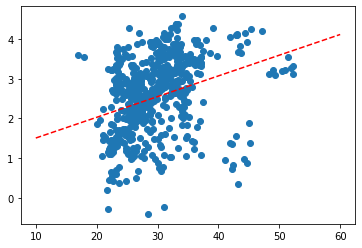

In [7]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""

pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

pooled_data_dict = {'N': len(logReligiosity),
               'x': giniNet,
               'y': logReligiosity}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model, data=pooled_data_dict, iter=1000, chains=2)

pooled_sample = pooled_fit.extract(permuted=True)

b0, m0 = pooled_sample['beta'].T.mean(1)

plt.scatter(giniNet, logReligiosity+0.1)
xvals = np.linspace(10, 60)
plt.plot(xvals, m0*xvals+b0, 'r--')

Unpooled Model

In [8]:
unpooled_model ="""
data {
  int<lower=0> N; 
  int<lower=1,upper=37> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[37] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = beta * x[i] + a[country[i]];
}
model {
  y ~ normal(y_hat, sigma);
}"""

unpooled_data = {'N': len(logReligiosity),
               'country': country+1,
               'x': giniNet,
               'y': logReligiosity}

unpooled_fit = pystan.stan(model_code=unpooled_model, data=unpooled_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17a8d518d123d6e87c0542c1c70b21df NOW.


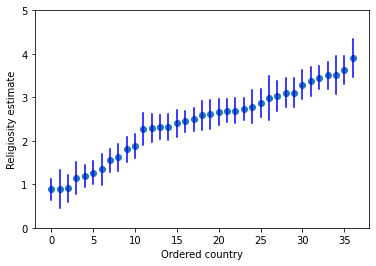

In [9]:
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=countries)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=countries)

order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-2,38); plt.ylim(0,5)
plt.ylabel('Religiosity estimate');plt.xlabel('Ordered country');

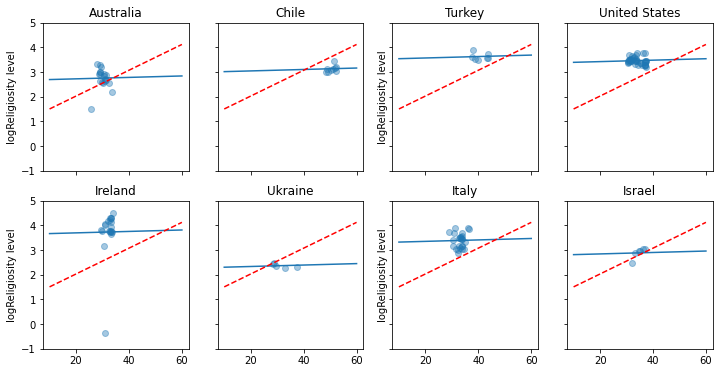

In [10]:
sample_countries = ('Australia', 'Chile', 'Turkey', 'United States', 'Ireland', 'Ukraine', 'Italy', 'Israel')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

m = unpooled_fit['beta'].mean(0)

for i,c in enumerate(sample_countries):
    y = trend2.logReligiosity[trend2.country==c]
    x = trend2.gini_net[trend2.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    b = unpooled_estimates[c]

    xvals = np.linspace(10,60)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity level')

Partial Pooling

In [11]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=37> country[N];
  vector[N] y;
} 
parameters {
  vector[37] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);
  y ~ normal(y_hat, sigma_y);
}"""

partial_pool_data = {'N': len(logReligiosity),
               'country': country+1,
               'y': logReligiosity}

partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce5f7bf87bce46f79e80b4acfb1757e8 NOW.


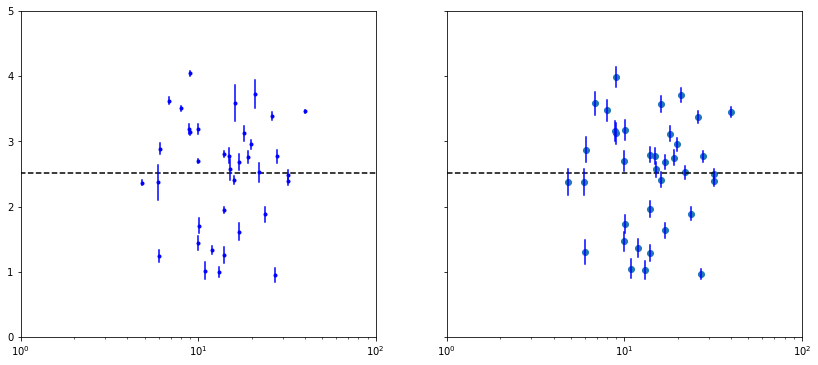

In [12]:
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, numberOfCountries = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=numberOfCountries)

n_country = trend2.groupby('country')['year'].count()
unpooled_means = trend2.groupby('country')['logReligiosity'].mean()
unpooled_sd = trend2.groupby('country')['logReligiosity'].std()
unpooled = pd.DataFrame({'n':n_country, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
samples, numberOfCountries = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_country.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 5)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_country.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

Difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes can be noticed.

Varying Intercept with control variable (rgdpl included)

In [13]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x1;
  vector[N] x2;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b1;
  real b2;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x1[i] * b1 + x2[i] * b2;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b1 ~ normal (0, 1);
  b2 ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

varying_intercept_data = {'N': len(logReligiosity),
                          'J': numberOfCountries,
                          'country': country+1,
                          'x1': giniNet,
                          'x2': rgdpl,
                          'y': logReligiosity}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8fcb7117693b818b93253442e8420d1f NOW.


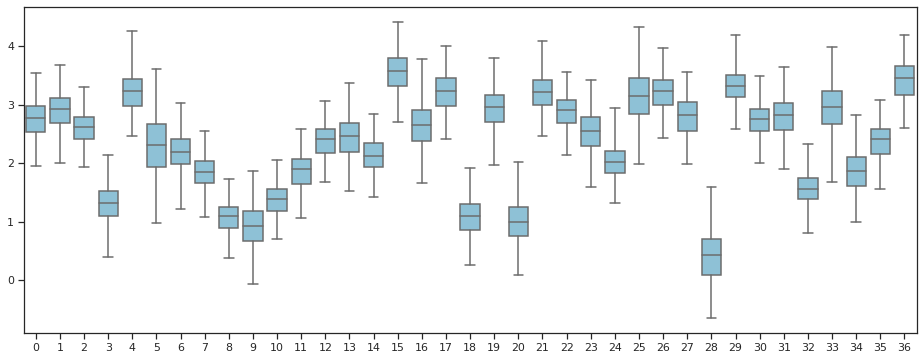

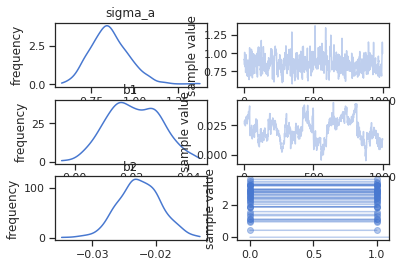

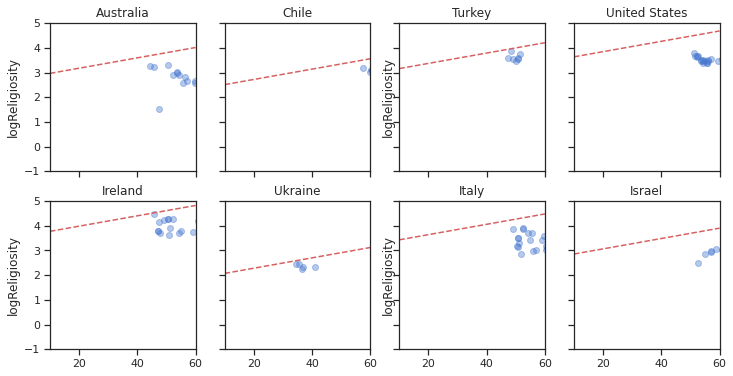

In [14]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

sample_countries = ('Australia', 'Chile', 'Turkey', 'United States', 'Ireland', 'Ukraine', 'Italy', 'Israel')

sns.set(style="ticks", palette="muted", color_codes=True)

plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b1', 'b2']);

varying_intercept_fit['b1'].mean()

xvals = np.arange(2)

bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b1'].mean()
mp2 = varying_intercept_fit['b2'].mean()

for bi in bp:
    plt.plot(xvals, mp2*xvals + mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i,c in enumerate(sample_countries):

    y = trend2.logReligiosity[trend2.country==c]
    x1 = trend2.gini_net[trend2.country==c]
    x2 = trend2.rgdpl[trend2.country==c]
    axes[i].scatter(x1 + np.random.randn(len(x1))*0.01 + x2 + np.random.randn(len(x2))*0.01, y, alpha=0.4)

    xvals = np.linspace(10, 60)
    
    axes[i].plot(xvals, mp*xvals+bp[countryLookup[c]], 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_xlim(10,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b1,0.021,0.009,0.005,0.038,0.002,0.001,20.0,20.0,21.0,82.0,1.06


<Figure size 1152x432 with 0 Axes>

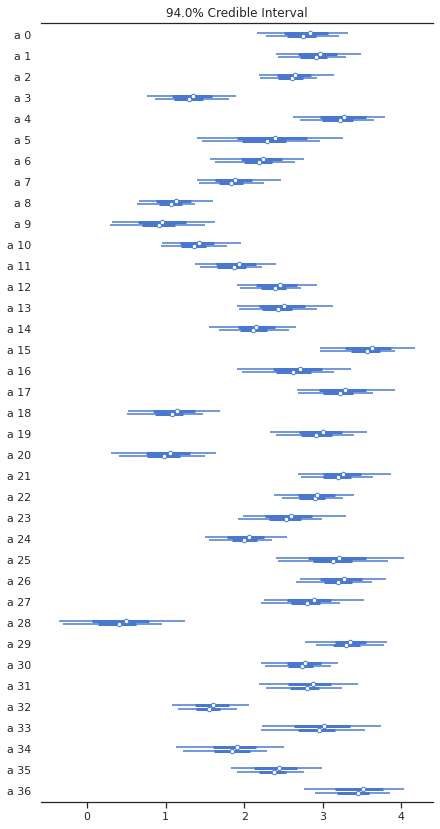

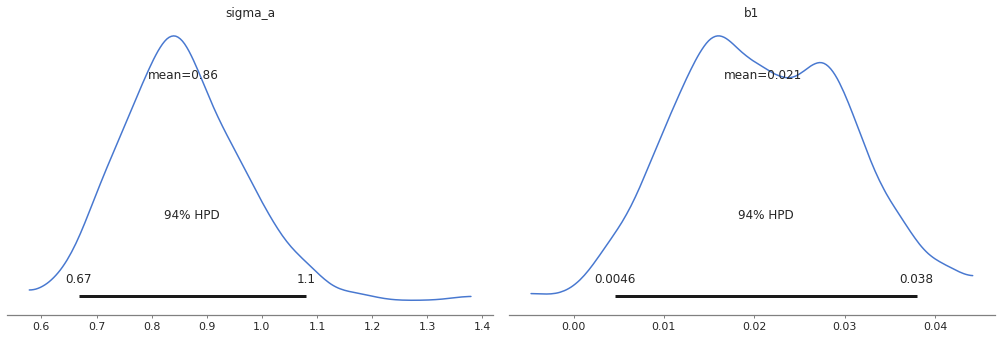

In [15]:
plt.figure(figsize=(16, 6))
forestplot(varying_intercept_fit, var_names=['a']);
plot_posterior(varying_intercept_fit, var_names=['sigma_a', 'b1']);
summary(varying_intercept_fit, var_names=['b1'])

Varying Intercept without control variable (rgdpl not included)

In [16]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

varying_intercept_data = {'N': len(logReligiosity),
                          'J': numberOfCountries,
                          'country': country+1,
                          'x': giniNet,
                          'y': logReligiosity}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be2696cd99a7d036b4929d82381f1d35 NOW.


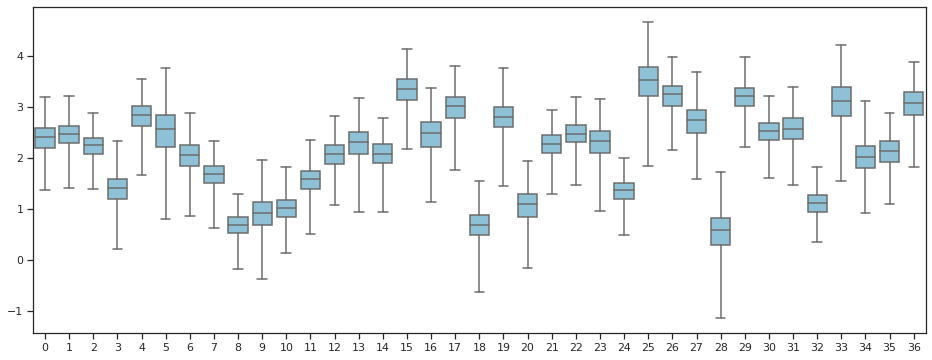

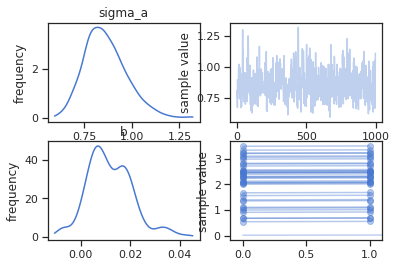

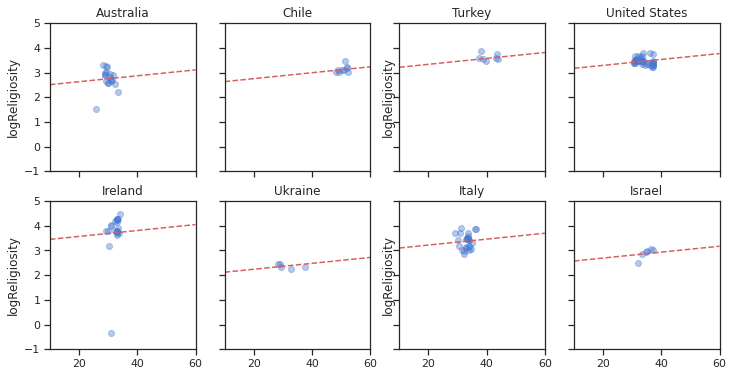

In [17]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

sns.set(style="ticks", palette="muted", color_codes=True)

plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b']);

varying_intercept_fit['b'].mean()

xvals = np.arange(2)

bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i,c in enumerate(sample_countries):

    y = trend2.logReligiosity[trend2.country==c]
    x = trend2.gini_net[trend2.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    xvals = np.linspace(10, 60)

    axes[i].plot(xvals, mp*xvals+bp[countryLookup[c]], 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_xlim(10,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity')

It is noticable that the partial pooling model provides reasonable estimates, even for countries with small sample sizes of different years.

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.012,0.009,-0.008,0.027,0.002,0.001,31.0,31.0,32.0,42.0,1.02


<Figure size 1152x432 with 0 Axes>

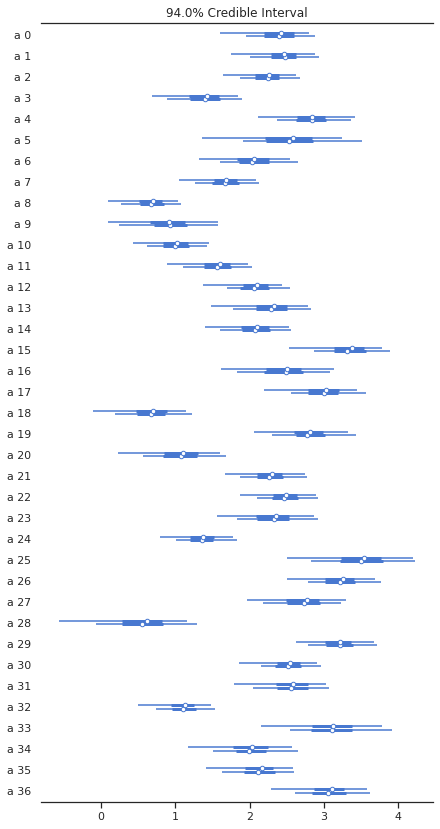

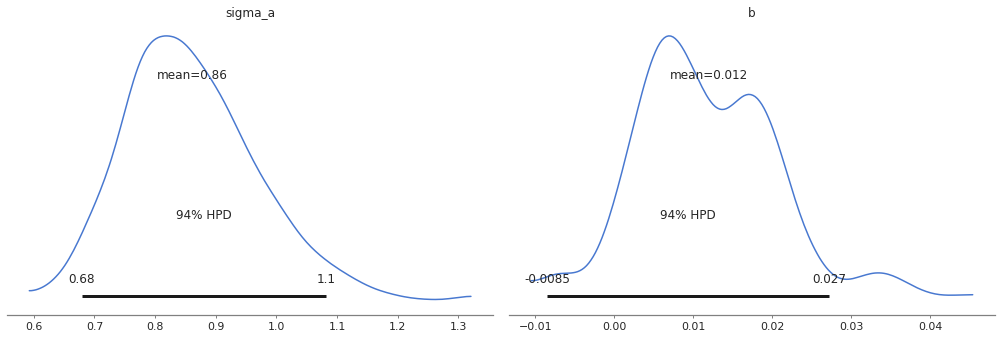

In [18]:
plt.figure(figsize=(16, 6))
forestplot(varying_intercept_fit, var_names=['a']);
plot_posterior(varying_intercept_fit, var_names=['sigma_a', 'b']);
summary(varying_intercept_fit, var_names=['b'])

Varying Intercept without control variable (rgdpl not included and beta prior changed)

Chosing highly informative prior beta value that is relatively far away from the posterior estimate from last model with little standard deviation and mu around 0.03 which is far from 0.01.

In [19]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b ~ normal (0.03, 0.01);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

varying_intercept_data = {'N': len(logReligiosity),
                          'J': numberOfCountries,
                          'country': country+1,
                          'x': giniNet,
                          'y': logReligiosity}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd0807e8f94baca4a7d131b74b57cf69 NOW.


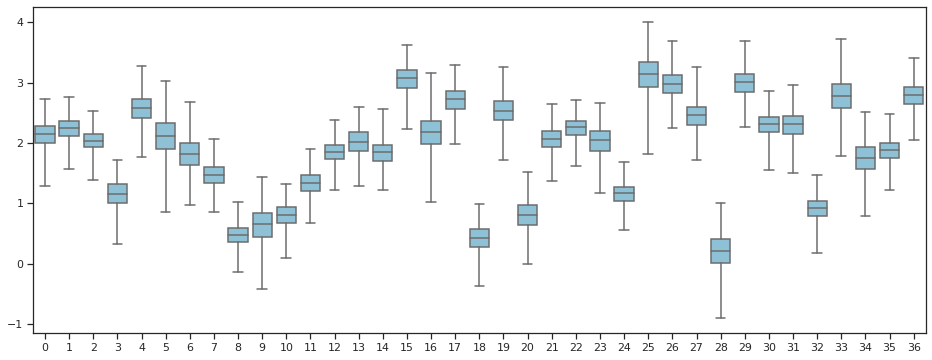

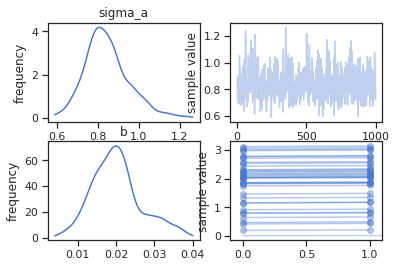

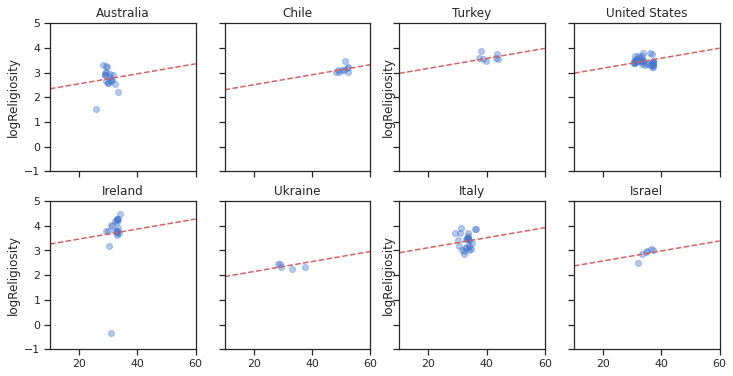

In [20]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

sns.set(style="ticks", palette="muted", color_codes=True)

plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b']);

varying_intercept_fit['b'].mean()

xvals = np.arange(2)

bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i,c in enumerate(sample_countries):

    y = trend2.logReligiosity[trend2.country==c]
    x = trend2.gini_net[trend2.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    xvals = np.linspace(10, 60)

    axes[i].plot(xvals, mp*xvals+bp[countryLookup[c]], 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_xlim(10,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.02,0.007,0.009,0.034,0.001,0.001,26.0,26.0,24.0,53.0,1.12


<Figure size 1152x432 with 0 Axes>

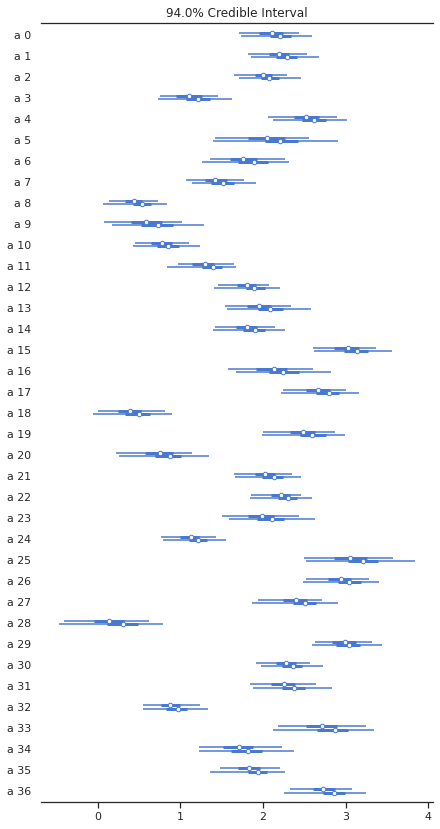

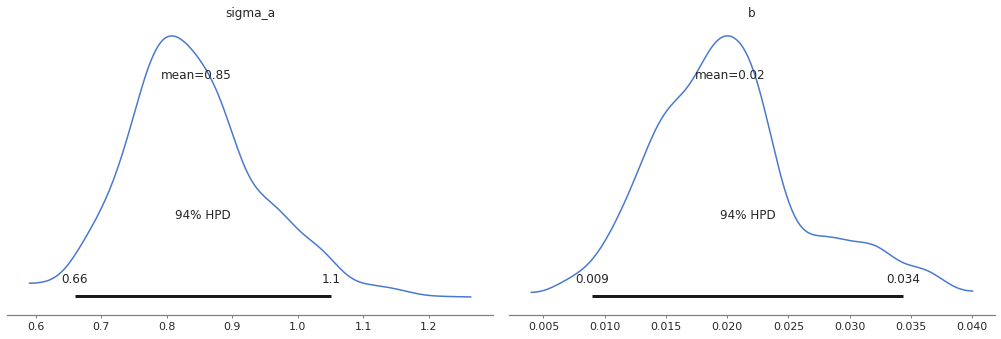

In [21]:
plt.figure(figsize=(16, 6))
forestplot(varying_intercept_fit, var_names=['a']);
plot_posterior(varying_intercept_fit, var_names=['sigma_a', 'b']);
summary(varying_intercept_fit, var_names=['b'])

Hierarchical Intercept

In [23]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;
  for (i in 1:N) {
    m[i] = a[country[i]] + u[i] * b[1];
    y_hat[i] = m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

hierarchical_intercept_data = {'N': len(logReligiosity),
                          'J': len(n_country),
                          'country': country+1,
                          'u': rgdpl,
                          'x': giniNet,
                          'y': logReligiosity}

hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept, data=hierarchical_intercept_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96d87bbff00054f025a592520fc972e3 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


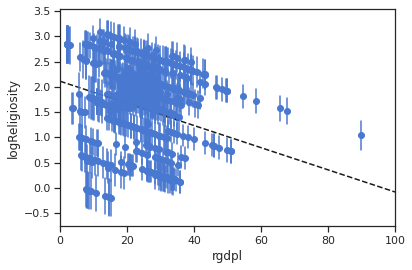

In [24]:
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
plt.scatter(rgdpl, m_means)
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
xvals = np.linspace(0, 100)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(0, 100)

m_se = hierarchical_intercept_fit['m'].std(axis=0)
for ui, m, se in zip(rgdpl, m_means, m_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('rgdpl'); plt.ylabel('logReligiosity')

xbar = trend2.groupby('country')['gini_net'].mean().rename(countryLookup).values

x_mean = xbar[country]

Comparision of Informative and Uninformative Prior

When the prior was uninformative, the posterior was very much determined by the data. On the other hand, when the prior is informative as in second model, the posterior is a mixture of the prior and the data. The more informative the prior, the more data is needed to "change" your beliefs (prior), so to speak because the posterior is very much driven by the prior information. But if there is a lot of data, the data will dominate the posterior distribution (they will overwhelm the prior).